In [1]:
import statsmodels
import scipy as sc
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import *
import statsmodels.stats.multitest as smm
import scipy
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("data/ab_browser_test.csv")

In [3]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [250]:
np.round(100 * 0.016135689824415822, 3)

1.614

In [247]:
data.query("slot == 'exp'").n_clicks.sum() / data.query("slot == 'control'").n_clicks.sum() - 1 

0.016135689824415822

In [4]:
np.round(data.query("slot == 'exp'").n_clicks.sum() / data.query("slot == 'control'").n_clicks.sum() * 100 - 100, 3)

1.614

In [16]:
data_exp = data.query("slot == 'exp'")
data_control = data.query("slot == 'control'")

In [28]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [37]:
median_exp = [np.median(x) for x in get_bootstrap_samples(data_exp.n_clicks.values, 3000)]
mean_exp = [np.mean(x) for x in get_bootstrap_samples(data_exp.n_clicks.values, 3000)]

median_control = [np.median(x) for x in get_bootstrap_samples(data_control.n_clicks.values, 3000)]
mean_control = [np.mean(x) for x in get_bootstrap_samples(data_control.n_clicks.values, 3000)]

In [38]:
stat_intervals(median_exp), stat_intervals(median_control)

(array([5., 5.]), array([4., 4.]))

In [39]:
stat_intervals([x - y for x, y in zip(median_exp, median_control)])

array([1., 1.])

In [40]:
stat_intervals([x - y for x, y in zip(mean_exp, mean_control)])

array([0.19540808, 0.40910994])

In [41]:
np.mean(mean_exp) - np.mean(mean_control)

0.3020011005665726

In [48]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

((array([496.00790142, 496.28984073, 496.44837459, 496.56078615,
         496.64886689, 496.72177909, 496.78427733, 496.83915848,
         496.88821233, 496.93265597, 496.97335597, 497.01095206,
         497.04593046, 497.07866967, 497.10947035, 497.13857541,
         497.16618407, 497.1924618 , 497.2175476 , 497.24155939,
         497.26459814, 497.28675096, 497.30809357, 497.3286922 ,
         497.34860517, 497.36788405, 497.38657472, 497.40471817,
         497.42235117, 497.43950686, 497.45621519, 497.47250333,
         497.48839601, 497.50391582, 497.51908341, 497.53391776,
         497.54843633, 497.56265521, 497.57658929, 497.59025236,
         497.60365721, 497.61681574, 497.62973905, 497.64243747,
         497.65492068, 497.66719774, 497.67927713, 497.69116683,
         497.70287433, 497.71440669, 497.72577056, 497.73697222,
         497.74801761, 497.75891232, 497.76966169, 497.78027074,
         497.79074426, 497.80108678, 497.81130262, 497.82139589,
         497.8313705 , 49

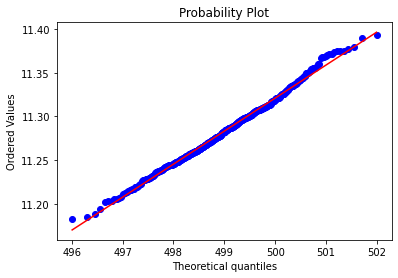

In [104]:
np.random.seed(0)
n = 500
n_boot_samples = get_bootstrap_samples(data_control.n_clicks.values, n)
n_boot_samples_mean = n_boot_samples.mean(axis=1)
control_boot_chi_squared = np.apply_along_axis(arr=n_boot_samples, func1d=lambda x: 1/499 * np.sum((x - x.mean()) ** 2), axis=1)

scipy.stats.probplot(n_boot_samples_mean, plot=pylab, sparams=499, dist="norm")

((array([409.75447609, 417.6076492 , 422.06789456, 425.24996033,
         427.75458277, 429.83540071, 431.6244473 , 433.19958802,
         434.61075771, 435.89197548, 437.06750372, 438.15527962,
         439.16895419, 440.11916758, 441.0143809 , 441.86143812,
         442.66595697, 443.43260794, 444.16531782, 444.86742108,
         445.54177438, 446.19084464, 446.81677748, 447.42145127,
         448.00652022, 448.57344901, 449.12354099, 449.6579613 ,
         450.17775596, 450.68386771, 451.17714938, 451.65837504,
         452.12824958, 452.58741674, 453.03646615, 453.47593922,
         453.90633437, 454.32811152, 454.74169597, 455.14748186,
         455.54583518, 455.93709642, 456.3215829 , 456.69959087,
         457.07139736, 457.43726183, 457.79742761, 458.1521233 ,
         458.50156388, 458.84595184, 459.1854781 , 459.52032292,
         459.85065667, 460.17664058, 460.49842735, 460.81616179,
         461.12998133, 461.44001656, 461.74639164, 462.04922476,
         462.3486285 , 46

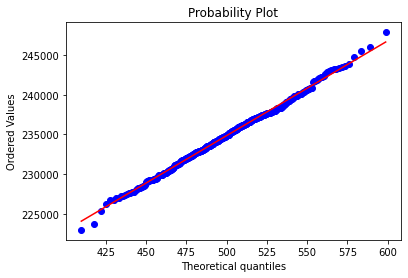

In [106]:
np.random.seed(0)
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=pylab)

In [105]:
0.9979748364604206 ** 2

0.9959537742082033

In [103]:
0.998641669882031 ** 2

0.9972851848247712

In [118]:
stats.mannwhitneyu(data_control.groupby("userID").agg({"n_clicks": "sum"}), data_exp.groupby("userID").agg({"n_clicks": "sum"}))

MannwhitneyuResult(statistic=array([3.89012599e+10]), pvalue=array([8.69429438e-75]))

In [170]:
control_user_n_clicks = data_control.groupby(["userID", "browser"]).agg({"n_clicks": "sum"})
exp_user_n_clicks = data_exp.groupby(["userID", "browser"]).agg({"n_clicks": "sum"})

In [220]:
arr = []
for i in data_control.browser.unique():
    arr.append([i] + list(multipletests(stats.mannwhitneyu(exp_user_n_clicks.xs(i, level=1), control_user_n_clicks.xs(i, level=1))[-1],\
                                       alpha=.05, method="holm"))[0:2])

In [223]:
arr

[['Browser #4', array([False]), array([0.81521235])],
 ['Browser #14', array([ True]), array([0.])],
 ['Browser #2', array([False]), array([0.05448772])],
 ['Browser #20', array([False]), array([0.90733313])],
 ['Browser #22', array([False]), array([0.51481103])],
 ['Browser #17', array([False]), array([0.0748012])]]

In [237]:
control_user_n_queries = data_control.groupby(["browser"]).agg({"n_queries": "sum"})
exp_user_n_queries = data_exp.groupby(["browser"]).agg({"n_queries": "sum"})

control_user_n_no_queries = data_control.groupby(["browser"]).agg({"n_nonclk_queries": "sum"})
exp_user_n_no_queries = data_exp.groupby(["browser"]).agg({"n_nonclk_queries": "sum"})

In [254]:
control_user_n_no_queries.iloc[:, 0] / control_user_n_queries.iloc[:, 0] * 100

browser
Browser #14    57.590411
Browser #17    36.299367
Browser #2     45.962747
Browser #20    40.540485
Browser #22    40.593977
Browser #4     46.970930
dtype: float64

In [239]:
exp_user_n_no_queries.iloc[:, 0] / exp_user_n_queries.iloc[:, 0] * 100

browser
Browser #14    43.755617
Browser #17    36.937413
Browser #2     44.982747
Browser #20    38.977376
Browser #22    39.853947
Browser #4     45.142942
dtype: float64